# Inspection of concrete structures



In [1]:
# import all libraries needed for this notebook
###############################################
import os
import numpy as np
import pandas as pd 
import shutil

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import autokeras as ak

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


from PIL import Image


In [5]:

# create an X and Y_cat for modelling
######################################
#

# Get the list of all imagefiles with their subdirectory
mergeinfo=[]
for i in ['CX', 'UX']:
    path = "../../../concrete_inspection_dataset/SDNET2018/X" + "/"+i
    dir_list = os.listdir(path)
    stop=1000
    for j in dir_list:
        full=path + "/" + j
        if i == 'CX':
            CRACK=[1,0]  # cracked
        else:
            CRACK=[0,1]  # not cracked

        mergeinfo.append([CRACK,full])
        if stop == 0:
            break
        else:
            stop-=1
 
    
dfinfo=pd.DataFrame(mergeinfo, columns=['label','path'])

#print(dfinfo.head())
#Use the path to read images.
SIZE=64
dfinfo['image'] = dfinfo['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
#Convert dataframe column of images into numpy array
X = np.asarray(dfinfo['image'].tolist())

X = X/255. # Scale values
Y=np.array(list(dfinfo['label']))

In [6]:
X.shape, Y.shape

((2002, 64, 64, 3), (2002, 2))

In [4]:
dfinfo.head()

,label,path,image
0,"[1, 0]",../../../concrete_inspection_dataset/SDNET2018...,"[[[160, 173, 182], [160, 173, 182], [165, 178,..."
1,"[1, 0]",../../../concrete_inspection_dataset/SDNET2018...,"[[[146, 158, 170], [146, 158, 170], [147, 161,..."
2,"[1, 0]",../../../concrete_inspection_dataset/SDNET2018...,"[[[156, 166, 175], [153, 163, 172], [149, 162,..."
3,"[1, 0]",../../../concrete_inspection_dataset/SDNET2018...,"[[[81, 81, 80], [89, 89, 89], [94, 94, 94], [1..."
4,"[1, 0]",../../../concrete_inspection_dataset/SDNET2018...,"[[[66, 66, 66], [73, 73, 73], [80, 80, 81], [8..."


In [10]:
x_train_auto.shape, y_train_auto.shape

((28, 64, 64, 3), (28, 2))

In [11]:
# let autokeras select a model
#
# testing/validating select of model
##################################################################################
#
# start model selection
#
XXmain, XXauto, YYmain, YYauto = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=True)
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(XXauto, YYauto, test_size=0.3, random_state=42, shuffle=True)


#
# start model selection
# Define classifier for autokeras. Check different models
# 
#clf = ak.ImageClassifier(num_classes=None, max_trials=5) #MaxTrials - max. number of keras models to try
clf = ak.ImageClassifier(
    num_classes=None,
    multi_label=True,
    loss=None,
    metrics=None,
    project_name="image_classifier",
    max_trials=25,
    directory=None,
    objective="accuracy",
    tuner=None,
    overwrite=False,
    seed=None,
    max_model_size=None
)

clf.fit(x_train_auto, y_train_auto, epochs=3)

#Evaluate the classifier on test data

_, acc = clf.evaluate(x_test_auto, y_test_auto)
print("Accuracy = ", (acc * 100.0), "%")

# get the final best performing model
model = clf.export_model()

#Save the best model 
model.save('../pybin/models/activemodel_auto_besttotrain')

INFO:tensorflow:Reloading Oracle from existing project .\image_classifier\oracle.json
INFO:tensorflow:Reloading Tuner from .\image_classifier\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
efficient         |vanilla           |image_block_1/block_type
True              |True              |image_block_1/normalize
True              |False             |image_block_1/augment
True              |None              |image_block_1/image_augmentation_1/horizontal_flip
False             |None              |image_block_1/image_augmentation_1/vertical_flip
0                 |None              |image_block_1/image_augmentation_1/contrast_factor
0                 |None              |image_block_1/image_augmentation_1/rotation_factor
0.1               |None              |image_block_1/image_augmentation_1/translation_factor
0                 |None              |image_block_1/image_augmentation_1/zoom_factor
True              |None              |image_block_

In [7]:
XXmain.shape, XXauto.shape, YYmain.shape, YYauto.shape
x_train_auto.shape, x_test_auto.shape, y_train_auto.shape, y_test_auto.shape

((56, 64, 64, 3), (25, 64, 64, 3), (56, 2), (25, 2))

In [8]:
# train the best model
######################
#

# Split the data in train/test set 
X_train, X_test, y_train, y_test = train_test_split(XXmain, YYmain, test_size=0.30, random_state=42, shuffle=True)

# Load the model to train
model = keras.models.load_model('../pybin/models/activemodel_auto_besttotrain')


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
# Train
history = model.fit(X_train,y_train,epochs=10)

# Test
res=model.evaluate(X_test,y_test)

# Save the model
model.save('../pybin/models/activemodel_autokeras')


Epoch 1/5


20/86 [=====>........................] - ETA: 20:38 - loss: 0.7415 - binary_accuracy: 0.7078 - false_negatives: 194.0000

KeyboardInterrupt: 

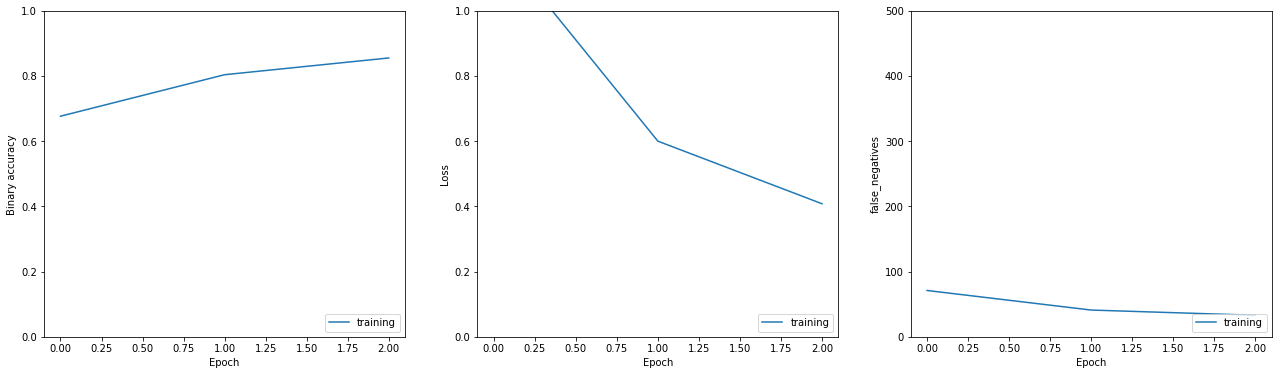

In [15]:
from matplotlib import pyplot as plt
import tensorflow

def plot_history(history : tensorflow.keras.callbacks.History):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
 
    fig, axs = plt.subplots(1,3, figsize=(22,6))
    axs[0].plot(history.history['binary_accuracy'], label='training')
    axs[0].set(xlabel = 'Epoch', ylabel='Binary accuracy', ylim=[0, 1])
    axs[0].legend(loc='lower right')

    axs[1].plot(history.history['loss'], label='training')
    
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 1])
    axs[1].legend(loc='lower right')

    axs[2].plot(history.history['false_negatives_1'], label = 'training')
 
    axs[2].set(xlabel = 'Epoch', ylabel='false_negatives', ylim=[0, 500])
    axs[2].legend(loc='lower right')

    
plot_history(history)

In [4]:
# Do a testprediction
###################
#
model = keras.models.load_model('../pybin/models/activemodel_best_trained9999')

# If importing an external image you'll have to rescale it (so : divide by 225.)
#The augmented data in X_test_augm is are already rescaled!
img=np.reshape(X_test[10], (-1, SIZE, SIZE, 3)) 
#
y_pred=model.predict(img)
# print result
print(y_pred)


NameError: name 'X_test' is not defined

ValueError: in user code:

    File "c:\Users\bmadmin\Desktop\Octocat\mohammedbouazzaoui\concrete_inspection\venv\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\bmadmin\Desktop\Octocat\mohammedbouazzaoui\concrete_inspection\venv\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\bmadmin\Desktop\Octocat\mohammedbouazzaoui\concrete_inspection\venv\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\bmadmin\Desktop\Octocat\mohammedbouazzaoui\concrete_inspection\venv\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\bmadmin\Desktop\Octocat\mohammedbouazzaoui\concrete_inspection\venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\bmadmin\Desktop\Octocat\mohammedbouazzaoui\concrete_inspection\venv\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(None, 256, 256, 3)


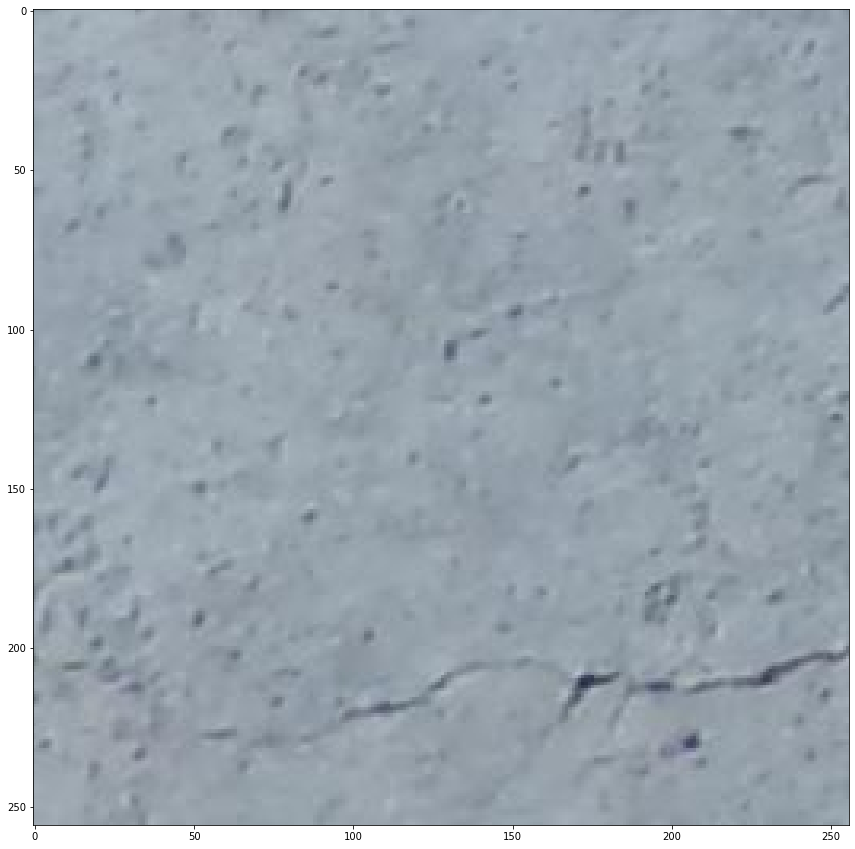

In [9]:
from matplotlib import pyplot as plt

STOP=0
SIZE=256
for pic in dfinfo['path']:
    img = np.asarray(Image.open(pic).resize((SIZE,SIZE)))
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    #Convert dataframe column of images into numpy array
    X = np.asarray(img.tolist())
    X = X/255. # Scale values
    Ximg=np.reshape(X, (-1, SIZE, SIZE, 3)) 
    #
    result=model.predict(Ximg)
    # print result
    print(result)
    if STOP == 10:
        break
    else:
        STOP+=1


